# ***Import Libraries:***

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
import gdown

url = "https://drive.google.com/file/d/1KCKfyIGbQi8a7bIYta3LM8dFStxVzVX-/view?pli=1"

file_id = url.split("/")[-2]
print(file_id)
prefix = 'https://drive.google.com/uc?/export=download&id='
gdown.download(prefix+file_id)
print("Data downloaded!")

1KCKfyIGbQi8a7bIYta3LM8dFStxVzVX-


Downloading...
From (original): https://drive.google.com/uc?/export=download&id=1KCKfyIGbQi8a7bIYta3LM8dFStxVzVX-
From (redirected): https://drive.google.com/uc?%2Fexport=download&id=1KCKfyIGbQi8a7bIYta3LM8dFStxVzVX-&confirm=t&uuid=d1ad478f-5cb3-439c-9566-0a1b0d505835
To: /kaggle/working/Shop DataSet.zip
100%|██████████| 1.78G/1.78G [00:12<00:00, 141MB/s] 

Data downloaded!


In [3]:
import zipfile
import os

# Path to the uploaded zip file
zip_path = '/kaggle/working/Shop DataSet.zip'  # Update this path as per your Drive structure
output_path = '/kaggle/working/data'

# Create the output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_path)

print("Data extracted to:", output_path)


Data extracted to: /kaggle/working/data


In [9]:
# Set dataset path
datasetPath = "/kaggle/working/data/Shop DataSet"
nonLiftersPath = os.path.join(datasetPath, "non shop lifters")
liftersPath = os.path.join(datasetPath, "shop lifters")

# ***Preparing Some Functions And Classes To Use :***

### *A method to Extract Frames From Videos*

### *A Method To Load Dataset*

In [11]:
def extractFrames(videoPath, frameCount=8):
    cap = cv2.VideoCapture(videoPath)
    frames = []
    totalFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for i in np.linspace(0, totalFrames - 1, frameCount).astype(int):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        success, frame = cap.read()
        if success:
            frame = cv2.resize(frame, (180, 180))
            frames.append(frame)
    cap.release()
    return frames

In [12]:
# Load dataset
data, labels = [], []
for label, folder in enumerate([nonLiftersPath, liftersPath]):
    for file in tqdm(os.listdir(folder), desc=f"Processing {folder}"):
        if file.endswith(".mp4"):
            frames = extractFrames(os.path.join(folder, file))
            for frame in frames:
                data.append(frame)
                labels.append(label)

Processing /kaggle/working/data/Shop DataSet/non shop lifters: 100%|██████████| 531/531 [01:42<00:00,  5.17it/s]
Processing /kaggle/working/data/Shop DataSet/shop lifters: 100%|██████████| 324/324 [02:18<00:00,  2.34it/s]


# ***Applying Preprocessing And Data Augmentation :***

In [13]:
# Convert to numpy arrays
data = np.array(data) / 255.0  # Normalize
labels = np.array(labels)

# Train-Test-Validation Split
trainData, tempData, trainLabels, tempLabels = train_test_split(data, labels, test_size=0.3, random_state=42)
valData, testData, valLabels, testLabels = train_test_split(tempData, tempLabels, test_size=0.5, random_state=42)

# Data Augmentation
dataGen = ImageDataGenerator(rotation_range=2, width_shift_range=0.25, height_shift_range=0.26, horizontal_flip=True)



# ***Train And Fine Tune Model :***

In [14]:
# Load Pretrained Model
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(180, 180, 3))
baseModel.trainable = False  # Freeze layers

# Fine-tune Model
x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=baseModel.input, outputs=outputs)

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000101),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Add Early Stopping to Prevent Overfitting
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train Model
history = model.fit(dataGen.flow(trainData, trainLabels, batch_size=4),
                    validation_data=(valData, valLabels),
                    epochs=150,
                    callbacks=[earlyStopping])

# Save Model
model.save("shopLiftingDetector.h5")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/150
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.6451 - loss: 0.6432 - val_accuracy: 0.6862 - val_loss: 0.4791
Epoch 2/150
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.7766 - loss: 0.4765 - val_accuracy: 0.8382 - val_loss: 0.3866
Epoch 3/150
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.7887 - loss: 0.4505 - val_accuracy: 0.8752 - val_loss: 0.3610
Epoch 4/150
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.7883 - loss: 0.4499 - val_accuracy: 0.6696 - val_loss: 0.5387
Epoch 5/150
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.8053 - loss: 0.4128 - val_accuracy: 0.7135 - val_loss: 0.4685
Epoch 6/150
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.8177 - loss: 0.4051 - val_accuracy: 0.8674 - val_loss: 0.3716
Epoch 7/150
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.8179 - loss: 0.4117 - val_accuracy: 0.8879 - val_loss: 0.3557
Epoch 8/150
1197/119

# ***Visualizating Model Performance :***

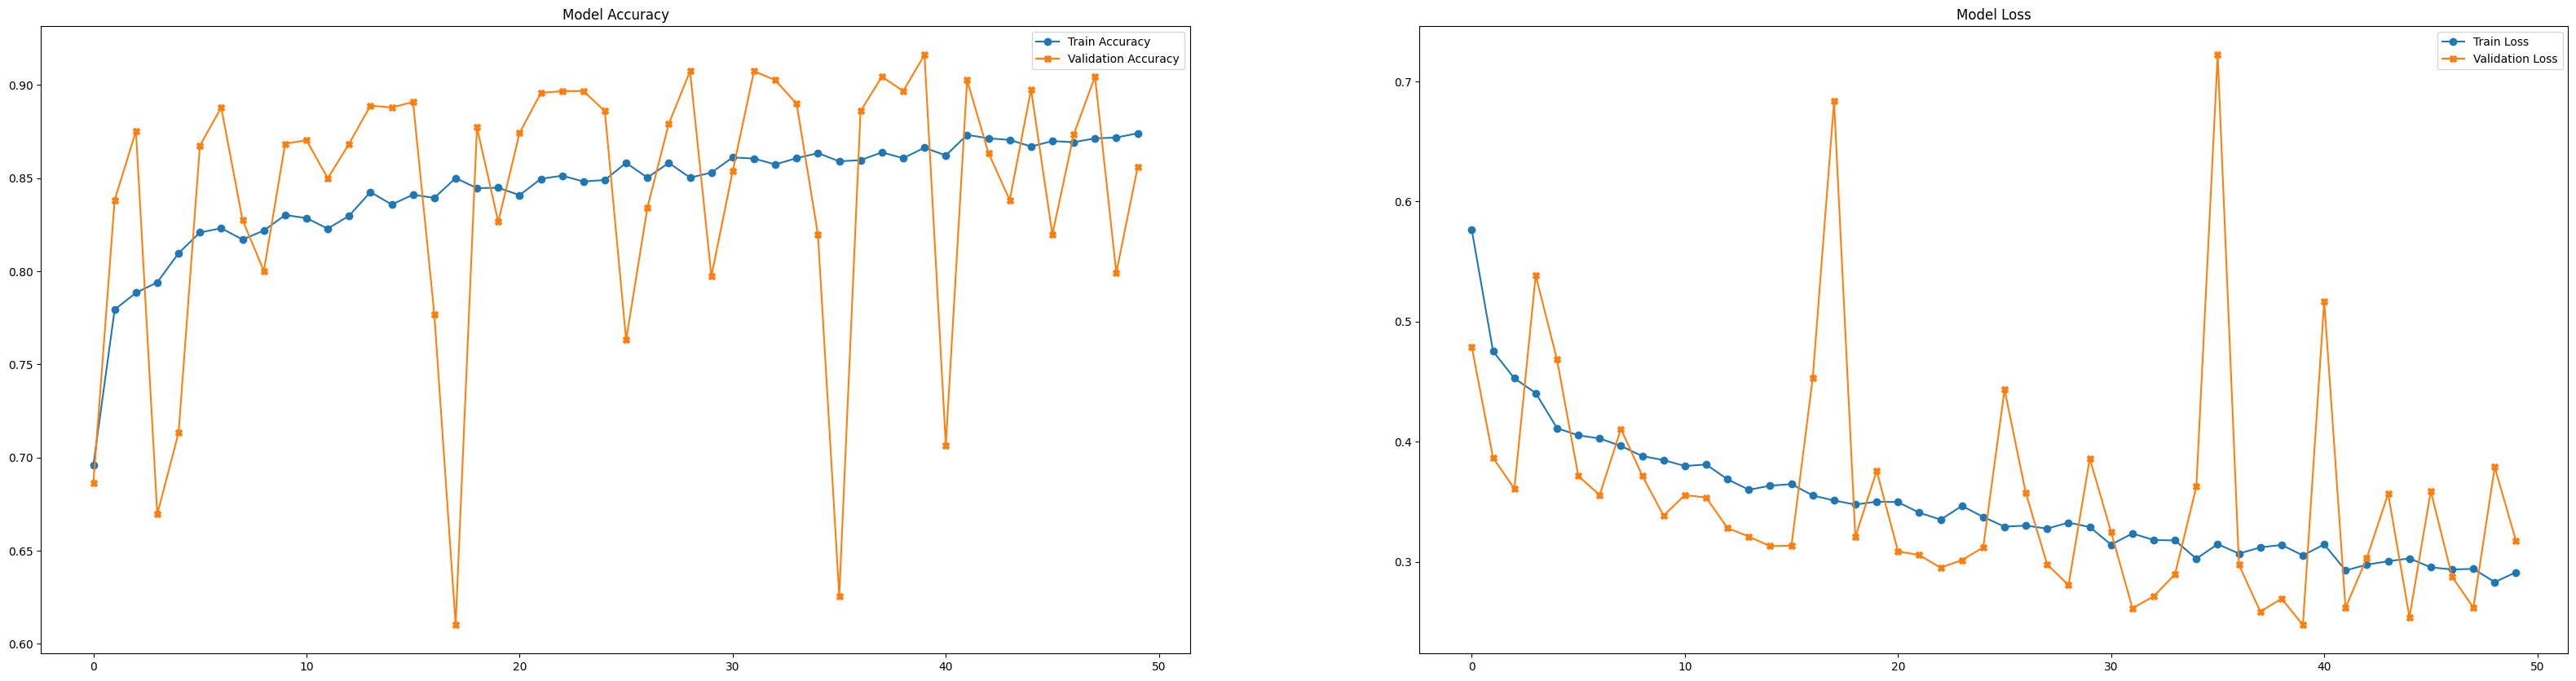

In [19]:
# Plot Training Performance
plt.figure(figsize=(40,10))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy',marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='X')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss',marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='X')
plt.legend()
plt.title('Model Loss')
plt.show()

# ***Visualize The Predictions :***

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


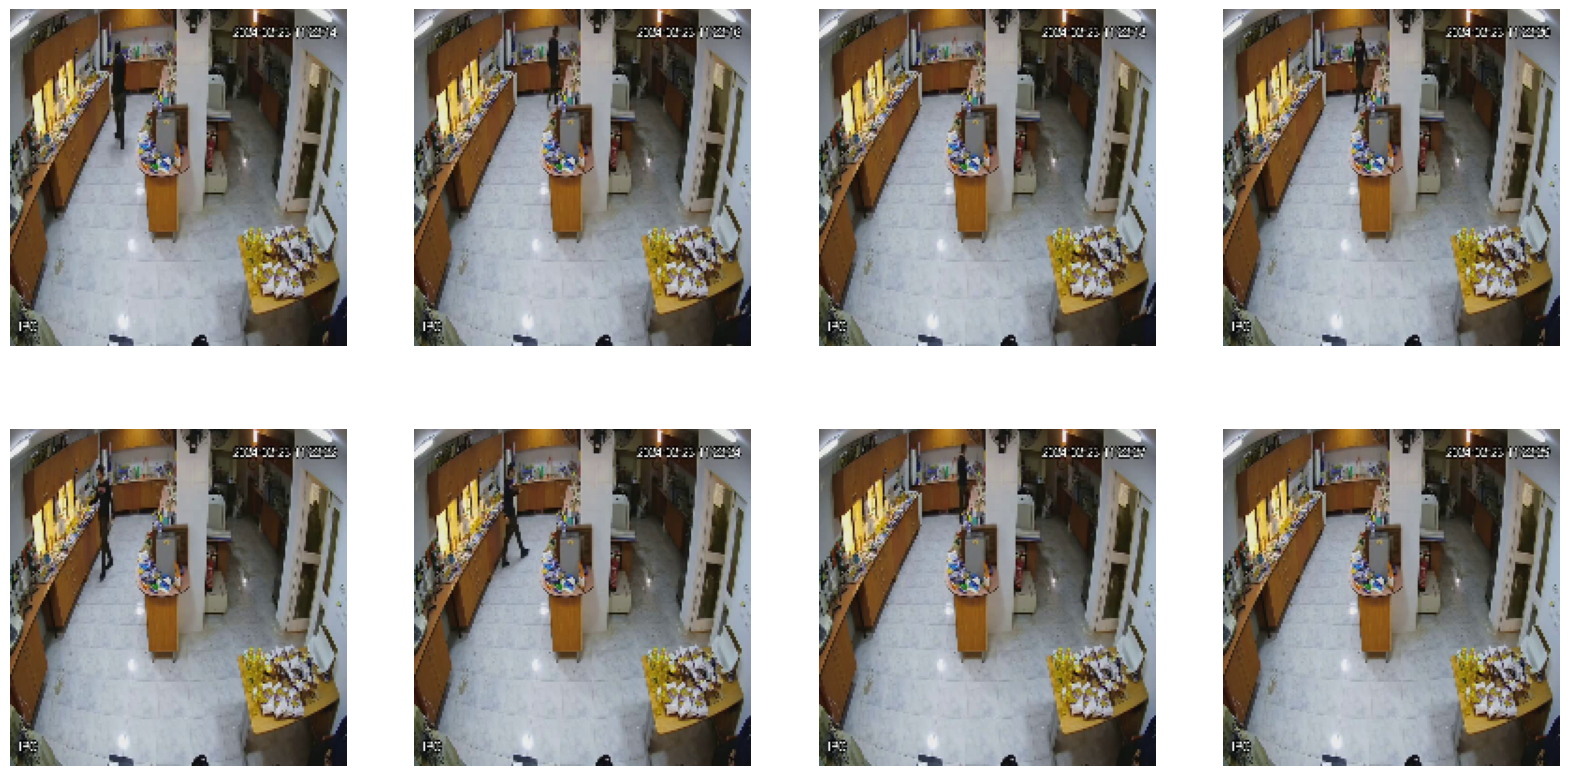

In [20]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model("/kaggle/working/shopLiftingDetector.h5")

# Function to extract frames from videos
def extractFrames(videoPath, frameCount=8):
    cap = cv2.VideoCapture(videoPath)
    frames = []
    totalFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for i in np.linspace(0, totalFrames - 1, frameCount).astype(int):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        success, frame = cap.read()
        if success:
            frame = cv2.resize(frame, (180, 180))  # Resize to match model input
            frames.append(frame)
    cap.release()
    return frames

# Make Predictions and Visualize
def plotPrediction(videoPath):
    frames = extractFrames(videoPath)
    predictions = model.predict(np.array(frames) / 255.0)
    personCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_fullbody.xml")
    tracker = None
    initBB = None
    
    plt.figure(figsize=(20, 10))
    for i, frame in enumerate(frames):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        
        if initBB is None:
            persons = personCascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=5, minSize=(30, 30))
            if len(persons) > 0:
                x, y, w, h = persons[0]
                initBB = (x, y, w, h)
                tracker = cv2.TrackerKCF_create()
                tracker.init(frame, initBB)
        
        if tracker is not None:
            success, box = tracker.update(frame)
            if success:
                x, y, w, h = [int(v) for v in box]
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)  # Green rectangle around detected person
        
        plt.subplot(2, 4, i + 1)
        plt.imshow(frame)
        plt.axis('off')
    plt.show()

# Example Usage
sampleVideo = os.path.join(liftersPath, os.listdir(liftersPath)[0])
plotPrediction(sampleVideo)